# Лабораторная работа №2

In [1]:
# Loading extension for reloading editable packages (pip install -e .)
%load_ext autoreload

In [2]:
# Reloading editable packages.
%autoreload
# from lab1.main import get_results

Вариант для задания №3:
1. Номер группы + 15 = 2 + 15 = 17
2. Номер варианта + 56 = 14 + 56 = 70
3. ИУ5 (Номер варианта + 21) = 14 + 21 = 35

In [3]:
import pickle
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from numpy.typing import ArrayLike
from PIL import Image
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from tqdm import tqdm

%matplotlib inline

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Классификация изображений CIFAR100
### Загрузка и распаковка набора данных CIFAR100

In [5]:
import os
import shutil
import urllib
from pathlib import Path

url = "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"
filename = "cifar-100-python.tar.gz"
model_path = Path("data")

model_path.mkdir(exist_ok=True)

file_path = model_path / filename

if not os.path.isfile(file_path):
    urllib.request.urlretrieve(url, file_path)
    shutil.unpack_archive(file_path, extract_dir=model_path)
    file_path.unlink()  # Remove archive after extracting it.

### Чтение тренировочной и тестовой выборки

In [6]:
def stem_extensions(filename: Path):
    extensions = "".join(filename.suffixes)

    return str(filename).removesuffix(extensions)

In [7]:
dataset_path = Path(stem_extensions(file_path))

with open(dataset_path / "train", "rb") as f:
    data_train = pickle.load(f, encoding="latin1")
with open(dataset_path / "test", "rb") as f:
    data_test = pickle.load(f, encoding="latin1")

# Классы по варианту.
CLASSES = [17, 70, 35]

train_X_raw = data_train["data"].reshape(-1, 3, 32, 32)
train_X_raw = np.transpose(train_X_raw, [0, 2, 3, 1])  # NCHW -> NHWC
train_y_raw = np.array(data_train["fine_labels"])
mask = np.isin(train_y_raw, CLASSES)
train_X = train_X_raw[mask].copy()
train_y = train_y_raw[mask].copy()
train_y = np.unique(train_y, return_inverse=1)[1]
del data_train

test_X = data_test["data"].reshape(-1, 3, 32, 32)
test_X = np.transpose(test_X, [0, 2, 3, 1])
test_y = np.array(data_test["fine_labels"])
mask = np.isin(test_y, CLASSES)
test_X = test_X[mask].copy()
test_y = test_y[mask].copy()
test_y = np.unique(test_y, return_inverse=1)[1]
del data_test

# print(train_y_raw.tolist())

In [8]:
def createImage(data: ArrayLike):
    return Image.fromarray(data).resize((256, 256))

In [9]:
# Source: https://stackoverflow.com/a/47334314
def grid_display(list_of_images, list_of_titles=[], no_of_columns=2, figsize=(10, 10)):
    fig = plt.figure(figsize=figsize)
    column = 0
    for i in range(len(list_of_images)):
        column += 1
        #  check for end of column and create a new figure
        if column == no_of_columns + 1:
            fig = plt.figure(figsize=figsize)
            column = 1
        fig.add_subplot(1, no_of_columns, column)
        plt.imshow(list_of_images[i])
        plt.axis("off")
        if len(list_of_titles) >= len(list_of_images):
            plt.title(list_of_titles[i])

class_id = 17:


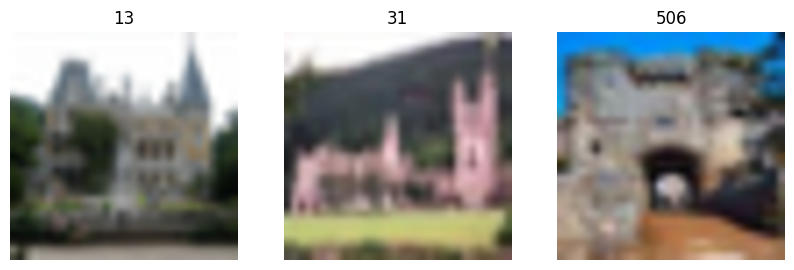

class_id = 70:


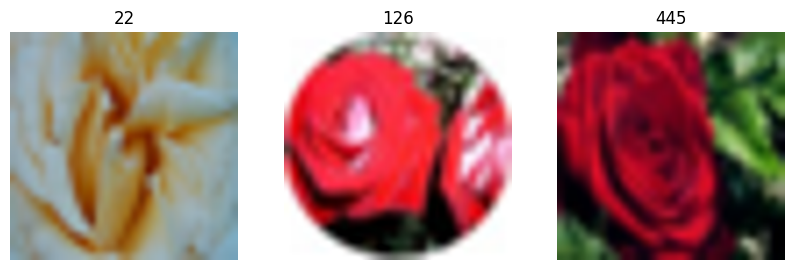

class_id = 35:


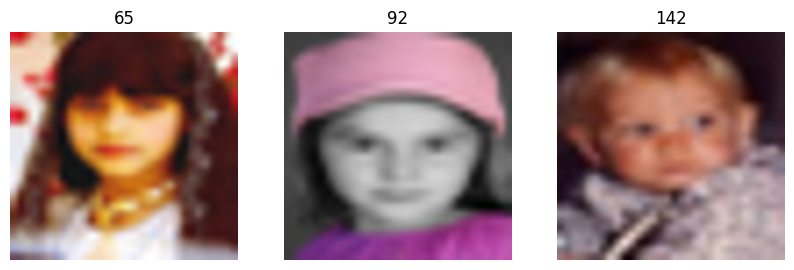

In [10]:
# По 3 экземпляра класса из выборки.
number_of_images_per_class_to_show = 3

for class_id in CLASSES:
    print(f"{class_id = }:")
    i = number_of_images_per_class_to_show
    image_index_for_class = -1
    class_images = []
    image_indices = []

    while i > 0:
        image_index_for_class = train_y_raw.tolist().index(
            class_id, image_index_for_class + 1
        )
        image_indices.append(image_index_for_class)
        class_images.append(createImage(train_X_raw[image_index_for_class]))
        i -= 1
    grid_display(class_images, image_indices, number_of_images_per_class_to_show)
    plt.show()

### Создание Pytorch DataLoader'a

In [11]:
def create_dataloader(batch_size=128):
    dataloader: dict[str, DataLoader] = {}
    for (X, y), part in zip([(train_X, train_y), (test_X, test_y)], ["train", "test"]):
        tensor_x = torch.Tensor(X)
        tensor_y = (
            F.one_hot(torch.Tensor(y).to(torch.int64), num_classes=len(CLASSES)) / 1.0
        )
        dataset = TensorDataset(tensor_x, tensor_y)  # создание объекта датасета
        dataloader[part] = DataLoader(
            dataset, batch_size=batch_size, shuffle=True
        )  # создание экземпляра класса DataLoader

    return dataloader

### Создание Pytorch модели свёрточной нейронной сети

In [28]:
HIDDEN_SIZE = 32


class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean).to(device)
        self.std = torch.tensor(std).to(device)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        return x.permute(0, 3, 1, 2)  # nhwc -> nm


class GlobalMaxPool2d(nn.Module):
    def __init__(self):
        super(GlobalMaxPool2d, self).__init__()

    def forward(self, input):
        out = F.adaptive_max_pool2d(input, output_size=1)
        return out.flatten(start_dim=1)


class Cifar100_CNN(nn.Module):
    def __init__(self, hidden_size=HIDDEN_SIZE, classes=100):
        super(Cifar100_CNN, self).__init__()
        # https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
        self.seq = nn.Sequential(
            Normalize([0.5074, 0.4867, 0.4411], [0.2011, 0.1987, 0.2025]),
            # первый способ уменьшения размерности картинки - через stride
            nn.Conv2d(3, hidden_size, 5, stride=4, padding=2),
            nn.ReLU(),
            # второй способ уменьшения размерности картинки - через слой пуллинг
            nn.Conv2d(hidden_size, hidden_size * 2, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(4),  # nn.MaxPool2d(4),
            nn.Flatten(),
            nn.Linear(hidden_size * 8, classes),
        )

    def forward(self, input):
        return self.seq(input)


model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
# NEW
model.to(device)
print(model(torch.rand(1, 32, 32, 3).to(device)))
summary(model, input_size=(32, 32, 3))
weights = list(model.parameters())[0].detach().numpy()
weights.shape

tensor([[0.1526, 0.0302, 0.1438]], grad_fn=<AddmmBackward0>)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Normalize-1            [-1, 3, 32, 32]               0
            Conv2d-2             [-1, 32, 8, 8]           2,432
              ReLU-3             [-1, 32, 8, 8]               0
            Conv2d-4             [-1, 64, 8, 8]          18,496
              ReLU-5             [-1, 64, 8, 8]               0
         AvgPool2d-6             [-1, 64, 2, 2]               0
           Flatten-7                  [-1, 256]               0
            Linear-8                    [-1, 3]             771
Total params: 21,699
Trainable params: 21,699
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.12
Params size (MB): 0.08
Estimated Total Size (MB): 0.22
------------------------------------------------

(32, 3, 5, 5)

### Обучение модели по эпохам

In [29]:
REDRAW_EVERY = 20
EPOCHS = 250


def train(
    model: nn.Module,
    criterion: nn.CrossEntropyLoss,
    optimizer: optim.Optimizer,
    dataloader: dict[str, DataLoader],
    epochs=EPOCHS,
):
    steps_per_epoch = len(dataloader["train"])
    steps_per_epoch_val = len(dataloader["test"])

    # New
    pbar = tqdm(total=epochs * steps_per_epoch)
    losses = []
    losses_val = []
    passed = 0
    for epoch in range(epochs):  # проход по набору данных несколько раз
        tmp = []
        model.train()
        for i, batch in enumerate(dataloader["train"], 0):
            # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
            inputs, labels = batch

            # очищение прошлых градиентов с прошлой итерации
            optimizer.zero_grad()

            # прямой + обратный проходы + оптимизация
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()

            # для подсчёта статистик
            accuracy = (
                labels.detach().argmax(dim=-1) == outputs.detach().argmax(dim=-1)
            ).to(torch.float32).mean().cpu() * 100
            tmp.append((loss.item(), accuracy.item()))
            pbar.update(1)
        losses.append(
            (
                np.mean(tmp, axis=0),
                np.percentile(tmp, 25, axis=0),
                np.percentile(tmp, 75, axis=0),
            )
        )
        tmp = []
        model.eval()
        with torch.no_grad():  # отключение автоматического дифференцирования
            for i, data in enumerate(dataloader["test"], 0):
                inputs, labels = data
                # на GPU
                # inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                accuracy = (labels.argmax(dim=-1) == outputs.argmax(dim=-1)).to(
                    torch.float32
                ).mean().cpu() * 100
                tmp.append((loss.item(), accuracy.item()))
        losses_val.append(
            (
                np.mean(tmp, axis=0),
                np.percentile(tmp, 25, axis=0),
                np.percentile(tmp, 75, axis=0),
            )
        )
        if (epoch + 1) % REDRAW_EVERY != 0:
            continue
        clear_output(wait=False)
        passed += pbar.format_dict["elapsed"]
        pbar = tqdm(total=EPOCHS * steps_per_epoch, miniters=5)
        pbar.update((epoch + 1) * steps_per_epoch)
        x_vals = np.arange(epoch + 1)
        _, ax = plt.subplots(1, 2, figsize=(15, 5))
        stats = np.array(losses)
        stats_val = np.array(losses_val)
        ax[1].set_ylim(stats_val[:, 0, 1].min() - 5, 100)
        ax[1].grid(axis="y")
        for i, title in enumerate(["CCE", "Accuracy"]):
            ax[i].plot(x_vals, stats[:, 0, i], label="train")
            ax[i].fill_between(x_vals, stats[:, 1, i], stats[:, 2, i], alpha=0.4)
            ax[i].plot(x_vals, stats_val[:, 0, i], label="val")
            ax[i].fill_between(
                x_vals, stats_val[:, 1, i], stats_val[:, 2, i], alpha=0.4
            )
            ax[i].legend()
            ax[i].set_title(title)
        plt.show()

    print("Обучение закончено за %s секунд" % passed)
    return dataloader

### Выбор функции потерь и оптимизатора градиентного спуска

 96%|█████████▌| 2880/3000 [00:03<00:00, 836.23it/s]


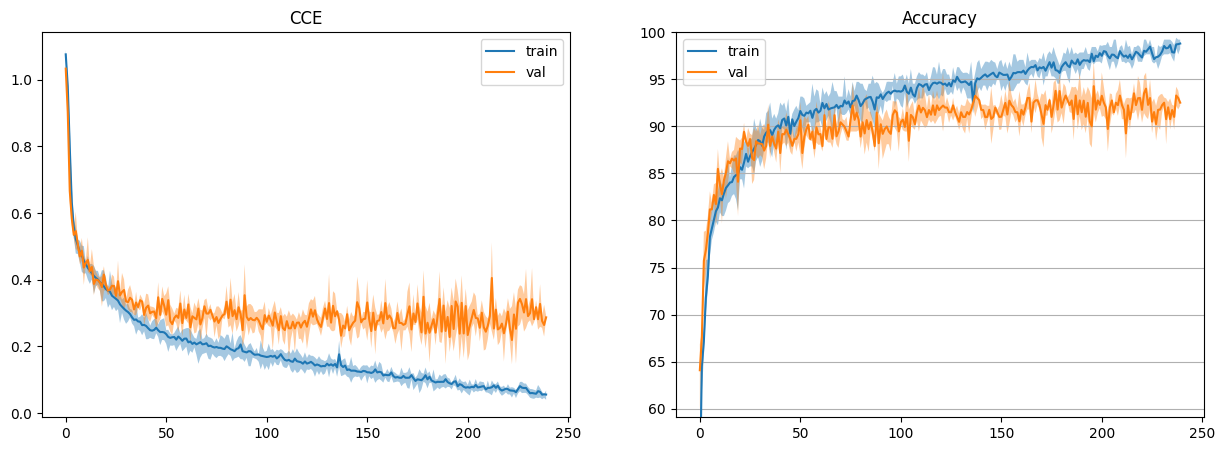

100%|██████████| 3000/3000 [00:01<00:00, 1573.20it/s]

Обучение закончено за 42.56879997253418 секунд


In [30]:
def train_classifier(
    model: nn.Module, learning_rate=5e-3, batch_size=128, epochs=EPOCHS, momentum=0.9
):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    dataloader = create_dataloader(batch_size=batch_size)

    return train(
        model,
        criterion=criterion,
        optimizer=optimizer,
        dataloader=dataloader,
        epochs=epochs,
    )


dataloader = train_classifier(model)

### Проверка качества модели по классам на обучающей и тестовой выборках

In [31]:
def report_classification_results(dataloader: DataLoader):
    y_pred = []
    y_true = []
    with torch.no_grad():  # отключение автоматического дифференцирования
        for _, data in enumerate(dataloader, 0):
            inputs, labels = data
            # на GPU
            # inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).detach().cpu().numpy()
            y_pred.append(outputs)
            y_true.append(labels.numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        print(
            classification_report(
                y_true.argmax(axis=-1),
                y_pred.argmax(axis=-1),
                digits=4,
                target_names=list(map(str, CLASSES)),
            )
        )

In [32]:
def compare_classification_reports(dataloader: dict[str, DataLoader]):
    for part in ["train", "test"]:
        print(part)
        report_classification_results(dataloader[part])
        part != "test" and print("-" * 53)


compare_classification_reports(dataloader)

train
              precision    recall  f1-score   support

          17     0.9960    0.9840    0.9899       500
          70     0.9823    0.9980    0.9901       500
          35     0.9980    0.9940    0.9960       500

    accuracy                         0.9920      1500
   macro avg     0.9921    0.9920    0.9920      1500
weighted avg     0.9921    0.9920    0.9920      1500

-----------------------------------------------------
test
              precision    recall  f1-score   support

          17     0.9789    0.9300    0.9538       100
          70     0.8692    0.9300    0.8986       100
          35     0.9286    0.9100    0.9192       100

    accuracy                         0.9233       300
   macro avg     0.9256    0.9233    0.9239       300
weighted avg     0.9256    0.9233    0.9239       300



### Анализ результатов обучения модели
Как видно, лучше всего был предсказан класс с идентификатором 17, представляющий
собой замки. Вероятнее всего это связано с количеством общих уникальных черт объектов
на картинках: у замков их намного меньше по сравнению с, например, ребёнком,
который может быть разного возраста, расы и может быть одет по-разному.

На лицо так же переобучение: в обучающей выборке характеристики были почти идеальными,
а в тестовых данных для некоторых классов средними. Скорректируем параметры для устранения
этого феномена в надежде улучшить качество модели.

Уменьшим количество эпох.

 32%|███▏      | 960/3000 [00:03<00:08, 244.91it/s]


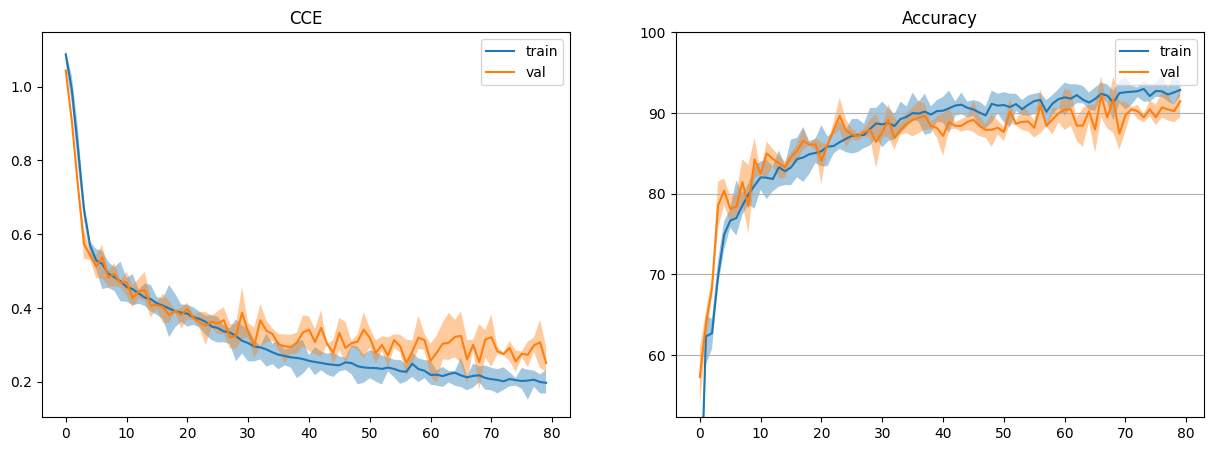

 33%|███▎      | 977/3000 [00:00<00:01, 1279.88it/s]

KeyboardInterrupt: 

In [33]:
model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
dataloader = train_classifier(model, epochs=500)
compare_classification_reports(dataloader)

In [ ]:
model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
dataloader = train_classifier(model, epochs=150)
compare_classification_reports(dataloader)

In [ ]:
model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
dataloader = train_classifier(model, epochs=160)
compare_classification_reports(dataloader)

## Изменим конфигурацию модели свёрточной сети

### 1. Поменяем тактику пуллинга
Пуллинг с помощью шага свёртки stride.

Отдельные пуллинг слои уберём, оставим свёрточные со stride > kernel.



 24%|██▍       | 720/3000 [00:02<00:06, 348.00it/s]


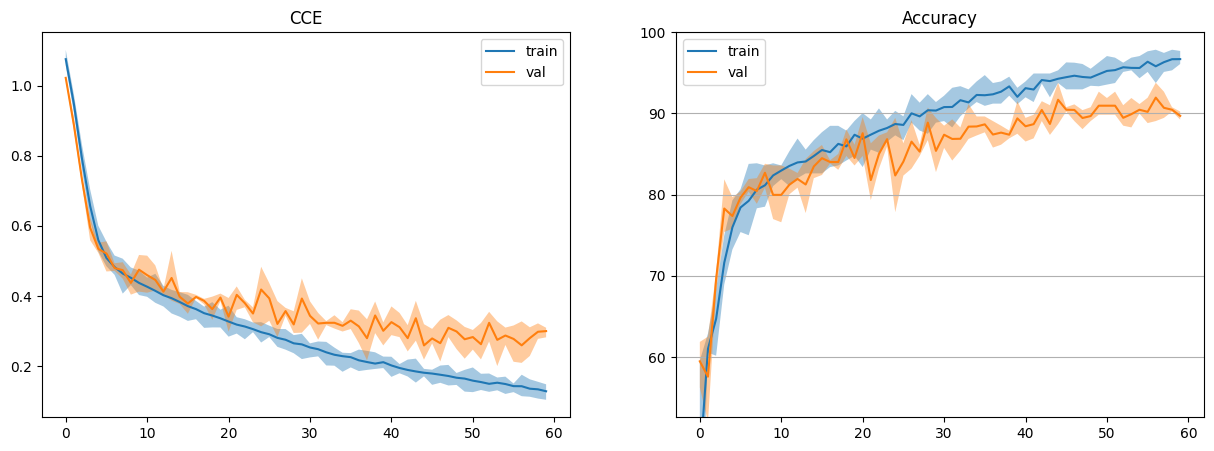



 24%|██▍       | 721/3000 [00:00<00:00, 2340.78it/s]

 24%|██▍       | 735/3000 [00:00<00:01, 1637.76it/s]

 25%|██▍       | 749/3000 [00:00<00:01, 1162.52it/s]

 25%|██▌       | 764/3000 [00:00<00:02, 834.46it/s] 

 26%|██▌       | 777/3000 [00:00<00:03, 622.33it/s]

 26%|██▋       | 792/3000 [00:00<00:04, 478.03it/s]

 27%|██▋       | 805/3000 [00:00<00:06, 341.45it/s]

 27%|██▋       | 817/3000 [00:01<00:08, 271.61it/s]

 28%|██▊       | 831/3000 [00:01<00:09, 230.29it/s]

 28%|██▊       | 842/3000 [00:01<00:11, 196.17it/s]

 28%|██▊       | 855/3000 [00:01<00:12, 176.18it/s]

 29%|██▉       | 867/3000 [00:01<00:13, 159.81it/s]

 29%|██▉       | 880/3000 [00:01<00:14, 150.51it/s]

 30%|███       | 900/3000 [00:01<00:04, 515.39it/s]


Обучение закончено за 6.082443714141846 секунд
train
              precision    recall  f1-score   support

          17     0.9898    0.9700    0.9798       500
          70     0.9665    0.9820    0.9742       500
          35     0.9861    0.9900    0.9880       500

    accuracy                         0.9807      1500
   macro avg     0.9808    0.9807    0.9807      1500
weighted avg     0.9808    0.9807    0.9807      1500

-----------------------------------------------------
test
              precision    recall  f1-score   support

          17     0.9783    0.9000    0.9375       100
          70     0.8198    0.9100    0.8626       100
          35     0.9072    0.8800    0.8934       100

    accuracy                         0.8967       300
   macro avg     0.9018    0.8967    0.8978       300
weighted avg     0.9018    0.8967    0.8978       300

Cifar100_CNN(
  (seq): Sequential(
    (0): Normalize()
    (1): Conv2d(3, 32, kernel_size=(5, 5), stride=(4, 4), padding=(2, 

In [55]:
class Cifar100_CNN(nn.Module):
    def __init__(self, hidden_size=HIDDEN_SIZE, classes=100):
        super(Cifar100_CNN, self).__init__()
        self.seq = nn.Sequential(
            Normalize([0.5074, 0.4867, 0.4411], [0.2011, 0.1987, 0.2025]),
            nn.Conv2d(3, hidden_size, kernel_size=5, stride=4, padding=2),
            nn.ReLU(),
            nn.Conv2d(hidden_size, hidden_size * 2, kernel_size=3, stride=4, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(hidden_size * 8, classes),
        )

    def forward(self, input):
        return self.seq(input)


model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
dataloader = train_classifier(model, epochs=75)
compare_classification_reports(dataloader)
print(model)

Добавим слой макс пуллинга.

Stride установим 2.


 64%|██████▍   | 1920/3000 [00:04<00:02, 460.43it/s]


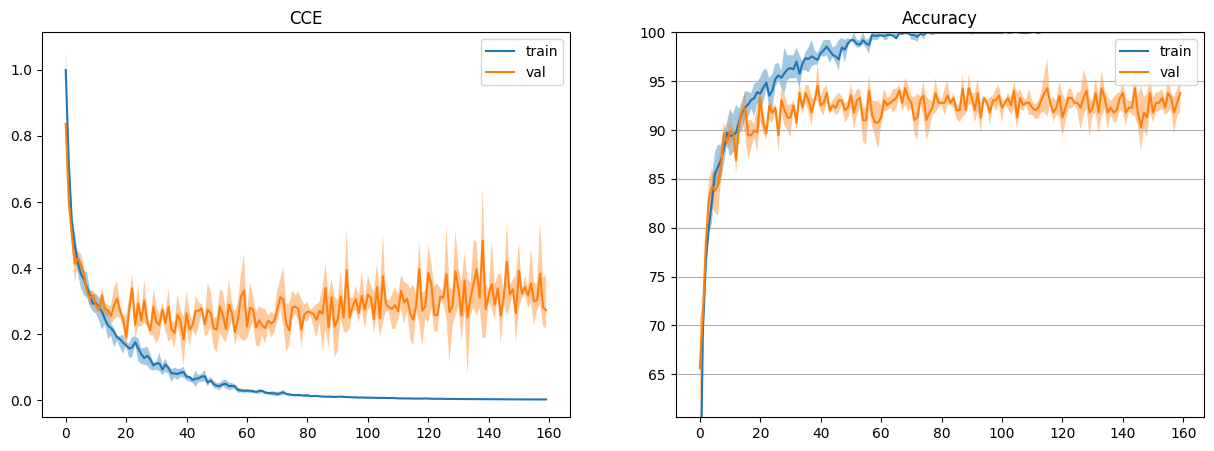

 64%|██████▍   | 1920/3000 [00:00<00:00, 5006.59it/s]

Обучение закончено за 32.402241706848145 секунд
train
              precision    recall  f1-score   support

          17     1.0000    1.0000    1.0000       500
          70     1.0000    1.0000    1.0000       500
          35     1.0000    1.0000    1.0000       500

    accuracy                         1.0000      1500
   macro avg     1.0000    1.0000    1.0000      1500
weighted avg     1.0000    1.0000    1.0000      1500

-----------------------------------------------------
test
              precision    recall  f1-score   support

          17     0.9505    0.9600    0.9552       100
          70     0.8922    0.9100    0.9010       100
          35     0.9381    0.9100    0.9239       100

    accuracy                         0.9267       300
   macro avg     0.9269    0.9267    0.9267       300
weighted avg     0.9269    0.9267    0.9267       300

Cifar100_CNN(
  (seq): Sequential(
    (0): Normalize()
    (1): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2,

In [58]:
class Cifar100_CNN(nn.Module):
    def __init__(self, hidden_size=HIDDEN_SIZE, classes=100):
        super(Cifar100_CNN, self).__init__()
        self.seq = nn.Sequential(
            Normalize([0.5074, 0.4867, 0.4411], [0.2011, 0.1987, 0.2025]),
            nn.Conv2d(3, hidden_size, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5, stride=2, padding=2),
            nn.Conv2d(hidden_size, hidden_size * 2, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Flatten(),
            nn.Linear(hidden_size * 8, classes),
        )

    def forward(self, input):
        return self.seq(input)


model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
dataloader = train_classifier(model, epochs=160)
compare_classification_reports(dataloader)
print(model)



 67%|██████▋   | 240/360 [00:03<00:01, 65.87it/s]


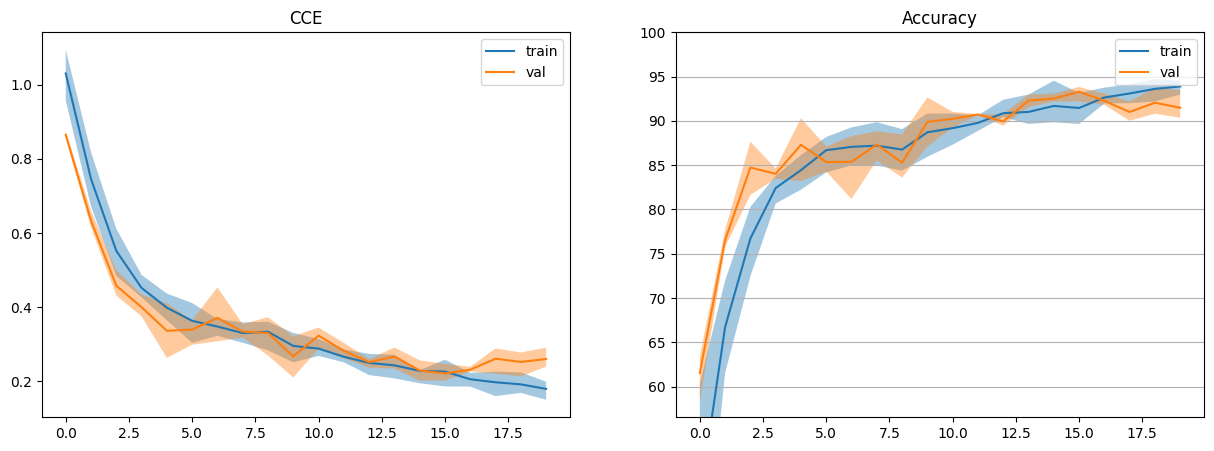



  8%|▊         | 241/3000 [00:00<00:04, 689.48it/s]

  8%|▊         | 249/3000 [00:00<00:05, 501.27it/s]

  9%|▊         | 256/3000 [00:00<00:07, 364.79it/s]

  9%|▉         | 264/3000 [00:00<00:09, 277.07it/s]

  9%|▉         | 270/3000 [00:00<00:12, 212.81it/s]

  9%|▉         | 277/3000 [00:00<00:17, 152.38it/s]

 10%|▉         | 285/3000 [00:01<00:20, 130.74it/s]

 10%|▉         | 291/3000 [00:01<00:24, 111.01it/s]

 10%|▉         | 299/3000 [00:01<00:27, 99.31it/s] 

 10%|█         | 305/3000 [00:01<00:30, 87.71it/s]

 10%|█         | 313/3000 [00:01<00:33, 80.16it/s]

 11%|█         | 320/3000 [00:01<00:34, 76.66it/s]

 11%|█         | 327/3000 [00:01<00:36, 72.77it/s]

 11%|█         | 334/3000 [00:01<00:37, 70.93it/s]

 11%|█▏        | 340/3000 [00:01<00:39, 66.62it/s]

 12%|█▏        | 347/3000 [00:02<00:39, 66.88it/s]

 12%|█▏        | 353/3000 [00:02<00:41, 63.40it/s]

 12%|█▏        | 360/3000 [00:02<00:16, 160.90it/s][A


Обучение закончено за 3.640639066696167 секунд
train
              precision    recall  f1-score   support

          17     0.9551    0.9780    0.9664       500
          70     0.9604    0.9220    0.9408       500
          35     0.9547    0.9700    0.9623       500

    accuracy                         0.9567      1500
   macro avg     0.9567    0.9567    0.9565      1500
weighted avg     0.9567    0.9567    0.9565      1500

-----------------------------------------------------
test
              precision    recall  f1-score   support

          17     0.9500    0.9500    0.9500       100
          70     0.9255    0.8700    0.8969       100
          35     0.8962    0.9500    0.9223       100

    accuracy                         0.9233       300
   macro avg     0.9239    0.9233    0.9231       300
weighted avg     0.9239    0.9233    0.9231       300



In [61]:
model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
dataloader = train_classifier(model, epochs=30)
compare_classification_reports(dataloader)

Поменяем слой макс пуллинга на усредняющий пуллинг



 40%|████      | 1200/3000 [00:03<00:05, 352.37it/s]


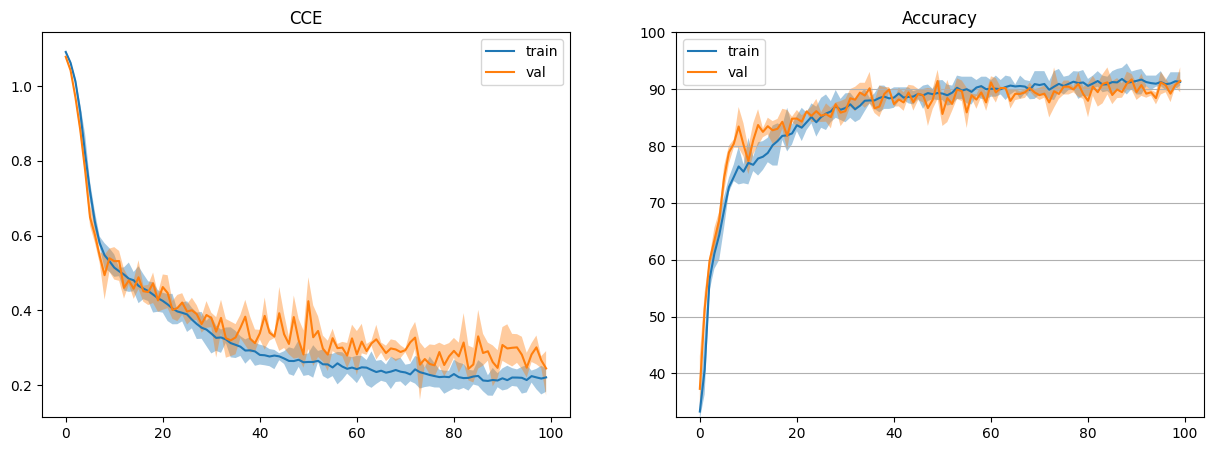

 40%|████      | 1200/3000 [00:00<00:00, 3856.91it/s]

Обучение закончено за 16.977234363555908 секунд
train
              precision    recall  f1-score   support

          17     0.9671    0.9400    0.9533       500
          70     0.8689    0.9280    0.8975       500
          35     0.9333    0.8960    0.9143       500

    accuracy                         0.9213      1500
   macro avg     0.9231    0.9213    0.9217      1500
weighted avg     0.9231    0.9213    0.9217      1500

-----------------------------------------------------
test
              precision    recall  f1-score   support

          17     0.9785    0.9100    0.9430       100
          70     0.8476    0.8900    0.8683       100
          35     0.8922    0.9100    0.9010       100

    accuracy                         0.9033       300
   macro avg     0.9061    0.9033    0.9041       300
weighted avg     0.9061    0.9033    0.9041       300

Cifar100_CNN(
  (seq): Sequential(
    (0): Normalize()
    (1): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2,

In [62]:
class Cifar100_CNN(nn.Module):
    def __init__(self, hidden_size=HIDDEN_SIZE, classes=100):
        super(Cifar100_CNN, self).__init__()
        self.seq = nn.Sequential(
            Normalize([0.5074, 0.4867, 0.4411], [0.2011, 0.1987, 0.2025]),
            nn.Conv2d(3, hidden_size, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=5, stride=2, padding=2),
            nn.Conv2d(hidden_size, hidden_size * 2, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=3, stride=2, padding=1),
            nn.Flatten(),
            nn.Linear(hidden_size * 8, classes),
        )

    def forward(self, input):
        return self.seq(input)


model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
dataloader = train_classifier(model, epochs=100)
compare_classification_reports(dataloader)
print(model)


 48%|████▊     | 1440/3000 [00:03<00:03, 443.65it/s]


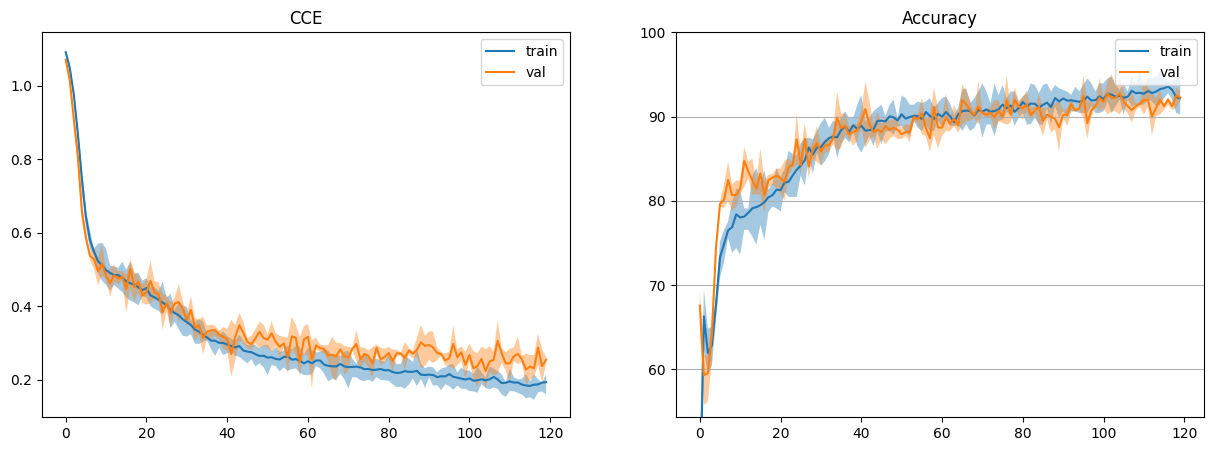

 48%|████▊     | 1440/3000 [00:00<00:00, 4535.92it/s]

Обучение закончено за 19.95038104057312 секунд
train
              precision    recall  f1-score   support

          17     0.9484    0.9560    0.9522       500
          70     0.9004    0.9040    0.9022       500
          35     0.9291    0.9180    0.9235       500

    accuracy                         0.9260      1500
   macro avg     0.9260    0.9260    0.9260      1500
weighted avg     0.9260    0.9260    0.9260      1500

-----------------------------------------------------
test
              precision    recall  f1-score   support

          17     0.9592    0.9400    0.9495       100
          70     0.8750    0.9100    0.8922       100
          35     0.9286    0.9100    0.9192       100

    accuracy                         0.9200       300
   macro avg     0.9209    0.9200    0.9203       300
weighted avg     0.9209    0.9200    0.9203       300



In [64]:
model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
dataloader = train_classifier(model, epochs=120)
compare_classification_reports(dataloader)



 56%|█████▌    | 1680/3000 [00:03<00:02, 503.94it/s]


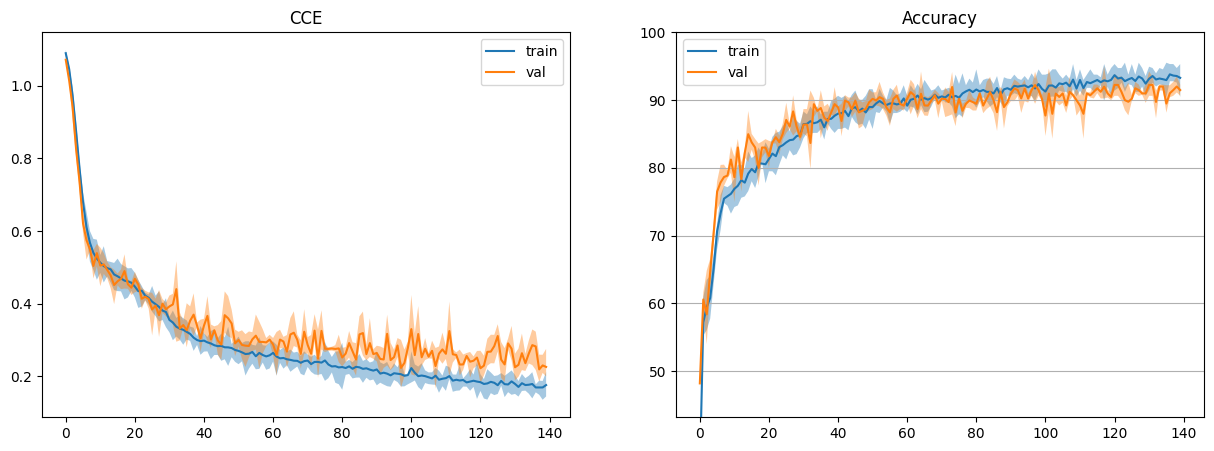

 56%|█████▌    | 1680/3000 [00:00<00:00, 4103.90it/s]

Обучение закончено за 23.62898588180542 секунд
train
              precision    recall  f1-score   support

          17     0.9504    0.9580    0.9542       500
          70     0.8973    0.9260    0.9114       500
          35     0.9563    0.9180    0.9367       500

    accuracy                         0.9340      1500
   macro avg     0.9346    0.9340    0.9341      1500
weighted avg     0.9346    0.9340    0.9341      1500

-----------------------------------------------------
test
              precision    recall  f1-score   support

          17     0.9681    0.9100    0.9381       100
          70     0.8571    0.9000    0.8780       100
          35     0.9109    0.9200    0.9154       100

    accuracy                         0.9100       300
   macro avg     0.9120    0.9100    0.9105       300
weighted avg     0.9120    0.9100    0.9105       300



In [65]:
model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
dataloader = train_classifier(model, epochs=140)
compare_classification_reports(dataloader)

In [ ]:
# -----

 32%|███▏      | 480/1500 [00:04<00:09, 107.72it/s]


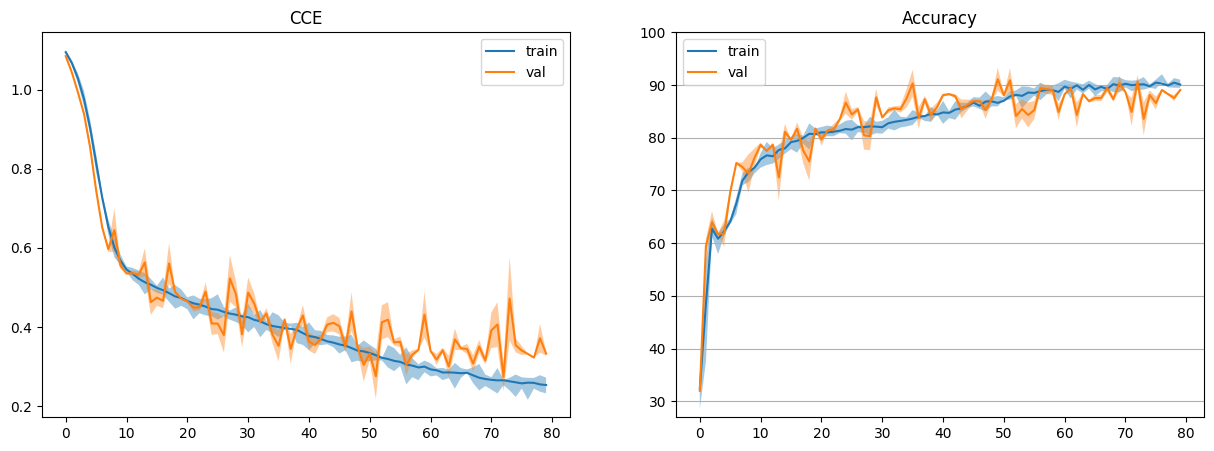

 32%|███▏      | 480/1500 [00:00<00:00, 1048.51it/s]

Обучение закончено за 16.88590931892395 секунд
train
              precision    recall  f1-score   support

          17     0.9294    0.9480    0.9386       500
          70     0.8698    0.8820    0.8759       500
          35     0.9172    0.8860    0.9013       500

    accuracy                         0.9053      1500
   macro avg     0.9055    0.9053    0.9053      1500
weighted avg     0.9055    0.9053    0.9053      1500

-----------------------------------------------------
test
              precision    recall  f1-score   support

          17     0.9474    0.9000    0.9231       100
          70     0.8447    0.8700    0.8571       100
          35     0.8922    0.9100    0.9010       100

    accuracy                         0.8933       300
   macro avg     0.8947    0.8933    0.8937       300
weighted avg     0.8947    0.8933    0.8937       300



In [21]:
model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
print(model)
dataloader = train_classifier(model, batch_size=256, epochs=80)
compare_classification_reports(dataloader)

7680it [00:06, 1120.91it/s]:00<?, ?it/s]


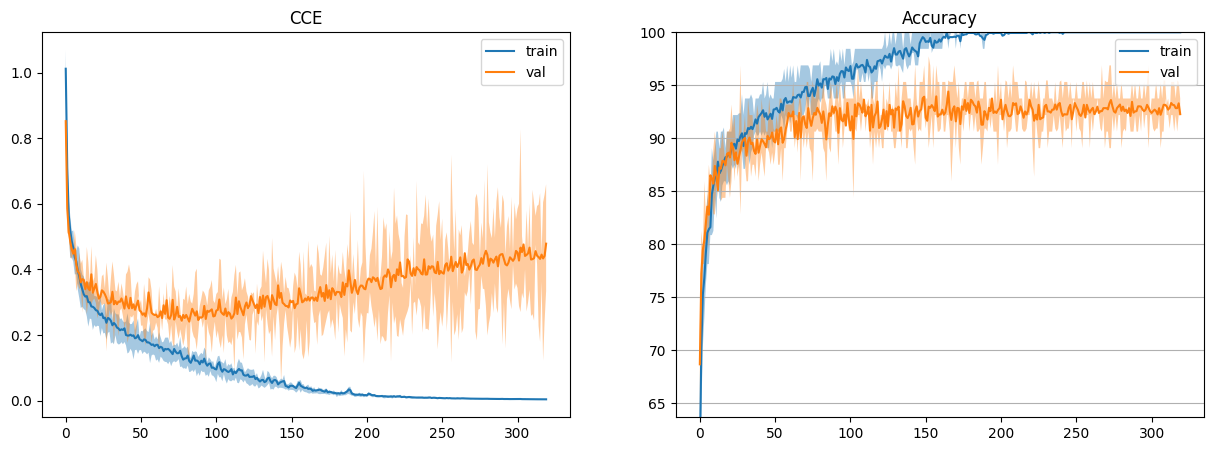

7680it [00:00, 17012.07it/s]            

Обучение закончено за 109.09697484970093 секунд
train
              precision    recall  f1-score   support

          17     1.0000    1.0000    1.0000       500
          70     1.0000    1.0000    1.0000       500
          35     1.0000    1.0000    1.0000       500

    accuracy                         1.0000      1500
   macro avg     1.0000    1.0000    1.0000      1500
weighted avg     1.0000    1.0000    1.0000      1500

-----------------------------------------------------
test
              precision    recall  f1-score   support

          17     0.9681    0.9100    0.9381       100
          70     0.8716    0.9500    0.9091       100
          35     0.9485    0.9200    0.9340       100

    accuracy                         0.9267       300
   macro avg     0.9294    0.9267    0.9271       300
weighted avg     0.9294    0.9267    0.9271       300



In [22]:
model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
print(model)
dataloader = train_classifier(model, batch_size=64, epochs=320)
compare_classification_reports(dataloader)


 40%|████      | 2400/6000 [00:07<00:10, 329.90it/s]


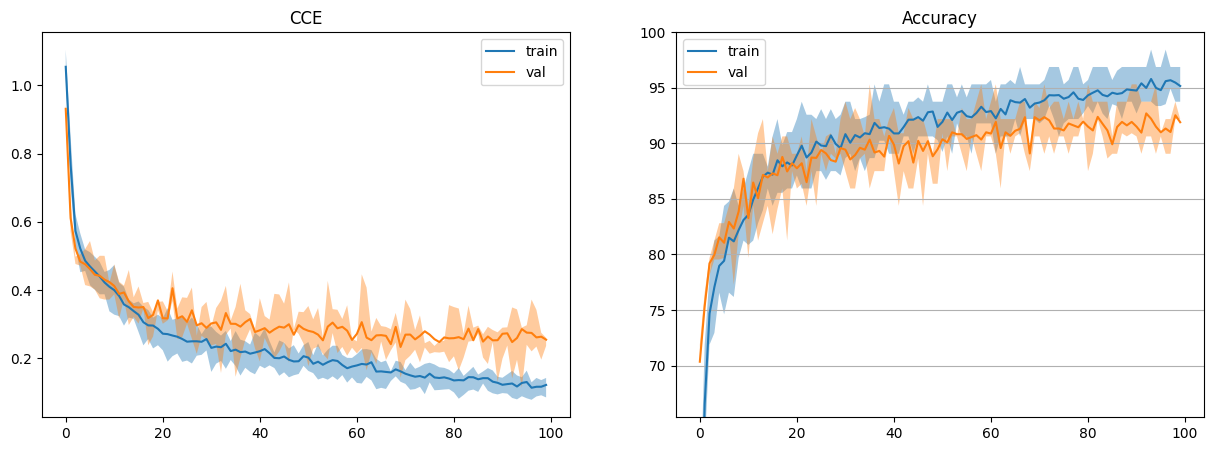


 44%|████▍     | 2640/6000 [00:03<00:04, 700.37it/s][A


Обучение закончено за 33.34468197822571 секунд
train
              precision    recall  f1-score   support

          17     0.9781    0.9820    0.9800       500
          70     0.9641    0.9680    0.9661       500
          35     0.9839    0.9760    0.9799       500

    accuracy                         0.9753      1500
   macro avg     0.9754    0.9753    0.9753      1500
weighted avg     0.9754    0.9753    0.9753      1500

-----------------------------------------------------
test
              precision    recall  f1-score   support

          17     0.9691    0.9400    0.9543       100
          70     0.8846    0.9200    0.9020       100
          35     0.9293    0.9200    0.9246       100

    accuracy                         0.9267       300
   macro avg     0.9277    0.9267    0.9270       300
weighted avg     0.9277    0.9267    0.9270       300



In [23]:
model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
print(model)
dataloader = train_classifier(model, batch_size=64, epochs=110)
compare_classification_reports(dataloader)

 64%|██████▍   | 1920/3000 [00:06<00:03, 291.20it/s]


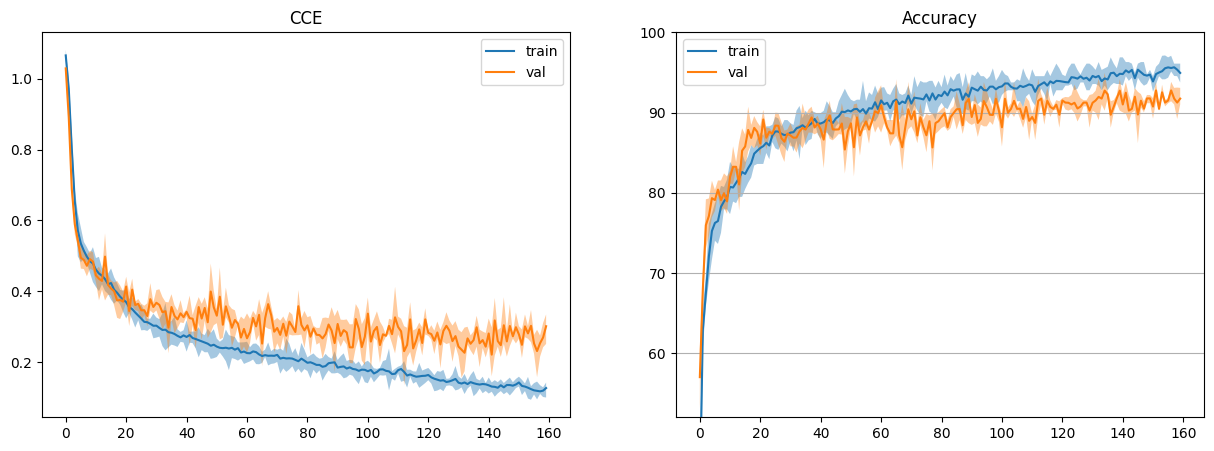

 64%|██████▍   | 1920/3000 [00:00<00:00, 3807.35it/s]

Обучение закончено за 52.826887130737305 секунд
train
              precision    recall  f1-score   support

          17     0.9698    0.9640    0.9669       500
          70     0.9595    0.9000    0.9288       500
          35     0.9213    0.9840    0.9516       500

    accuracy                         0.9493      1500
   macro avg     0.9502    0.9493    0.9491      1500
weighted avg     0.9502    0.9493    0.9491      1500

-----------------------------------------------------
test
              precision    recall  f1-score   support

          17     0.9688    0.9300    0.9490       100
          70     0.8958    0.8600    0.8776       100
          35     0.8796    0.9500    0.9135       100

    accuracy                         0.9133       300
   macro avg     0.9147    0.9133    0.9133       300
weighted avg     0.9147    0.9133    0.9133       300



In [24]:
class Cifar100_CNN_3(nn.Module):
    def __init__(self, hidden_size=HIDDEN_SIZE, classes=100):
        super(Cifar100_CNN, self).__init__()
        # https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
        self.seq = nn.Sequential(
            Normalize([0.5074, 0.4867, 0.4411], [0.2011, 0.1987, 0.2025]),
            # первый способ уменьшения размерности картинки - через stride
            nn.Conv2d(3, hidden_size, 5, stride=2, padding=2),
            nn.ReLU(),
            # второй способ уменьшения размерности картинки - через слой пуллинг
            nn.Conv2d(hidden_size, hidden_size * 2, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_size * 2, hidden_size * 3, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(4),  # nn.MaxPool2d(4),
            nn.Flatten(),
            nn.Linear(hidden_size * 8, classes),
        )

    def forward(self, input):
        return self.seq(input)


model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
print(model)
dataloader = train_classifier(model, epochs=160)
compare_classification_reports(dataloader)

In [25]:
model_path = Path("models")
model_filename = "cifar_cnn.pt"

model_path.mkdir(exist_ok=True)

model_file_path = model_path / model_filename

torch.save(model, model_file_path)
# загрузка
new_model_2 = torch.load(model_file_path)
new_model_2.eval()

Cifar100_CNN(
  (seq): Sequential(
    (0): Normalize()
    (1): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=4, stride=4, padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=3, bias=True)
  )
)

In [26]:
# входной тензор для модели
onnx_model_filename = "cifar100_cnn.onnx"
x = torch.randn(1, 32, 32, 3, requires_grad=True).to(device)
torch_out = model(x)

# экспорт модели
torch.onnx.export(
    model,  # модель
    x,  # входной тензор (или кортеж нескольких тензоров)
    model_path/onnx_model_filename,  # куда сохранить (либо путь к файлу либо fileObject)
    export_params=True,  # сохраняет веса обученных параметров внутри файла модели
    opset_version=9,  # версия ONNX
    do_constant_folding=True,  # следует ли выполнять укорачивание констант для оптимизации
    input_names=["input"],  # имя входного слоя
    output_names=["output"],  # имя выходного слоя
    dynamic_axes={
        "input": {
            0: "batch_size"
        },  # динамичные оси, в данном случае только размер пакета
        "output": {0: "batch_size"},
    },
)

In [27]:
# входной тензор для модели
onnx_model_filename = "cifar100_fc.onnx"
x = torch.randn(1, 32, 32, 3, requires_grad=True).to(device)
torch_out = model(x)

# экспорт модели
torch.onnx.export(
    model,  # модель
    x,  # входной тензор (или кортеж нескольких тензоров)
    model_path/onnx_model_filename,  # куда сохранить (либо путь к файлу либо fileObject)
    export_params=True,  # сохраняет веса обученных параметров внутри файла модели
    opset_version=9,  # версия ONNX
    do_constant_folding=True,  # следует ли выполнять укорачивание констант для оптимизации
    input_names=["input"],  # имя входного слоя
    output_names=["output"],  # имя выходного слоя
    dynamic_axes={
        "input": {
            0: "batch_size"
        },  # динамичные оси, в данном случае только размер пакета
        "output": {0: "batch_size"},
    },
)